Autoreload magic

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore')

Set sys and import data sampler

In [2]:
import sys

import tensorflow as tf

sys.path.append('/Users/tmo/Nodes/bandits/')

DATA_PATH = '/Users/tmo/Data/bandits/'

from src.sample_jester_data import sample_jester_data
from src.run_bandit import plot_model_actions, run_bandit
from src.linear_full_posterior_sampling import LinearFullPosteriorSampling
from src.neural_linear_sampling import NeuralLinearPosteriorSampling

Sample data

In [3]:
dataset, opt_rewards, opt_actions, num_actions, context_dim = sample_jester_data(DATA_PATH+'jester/jester_data_40jokes_19181users.npy', 
                                                                                 num_contexts=2000,
                                                                                 pct_zero=0,
                                                                                 shuffle_rows=False,
                                                                                 shuffle_cols=False)

In [4]:
dataset

array([[ 7.82,  1.12, -8.4 , ...,  4.95,  8.3 , -9.85],
       [ 4.71,  7.57,  3.4 , ...,  0.73,  1.12,  3.3 ],
       [ 3.93,  2.91, -8.3 , ...,  6.65,  7.28, -3.64],
       ...,
       [ 7.82,  5.24,  5.78, ..., -9.76,  7.04, -9.08],
       [ 6.46, -1.89, -1.12, ...,  6.21,  8.74, -1.89],
       [ 8.01, -7.43,  3.69, ...,  7.52,  0.53,  4.13]])

Set parameters for the two test models

In [5]:
hparams_linear = tf.contrib.training.HParams(num_actions=num_actions, 
                                             context_dim=context_dim, 
                                             a0=6,
                                             b0=6,
                                             lambda_prior=0.25,
                                             initial_pulls=2)

linear_bandit = LinearFullPosteriorSampling(name='linear_bandit', hparams=hparams_linear)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
hparams_nlinear = tf.contrib.training.HParams(num_actions=num_actions,
                                                context_dim=context_dim,
                                                init_scale=0.3,
                                                activation=tf.nn.relu,
                                                layer_sizes=[50],
                                                batch_size=512,
                                                activate_decay=True,
                                                initial_lr=0.1,
                                                max_grad_norm=5.0,
                                                show_training=False,
                                                freq_summary=1000,
                                                buffer_s=-1,
                                                initial_pulls=2,
                                                reset_lr=True,
                                                lr_decay_rate=0.5,
                                                training_freq=1,
                                                training_freq_network=50,
                                                training_epochs=100,
                                                a0=6,
                                                b0=6,
                                                lambda_prior=0.25,
                                                verbose=False)

neural_bandit = NeuralLinearPosteriorSampling('neural_bandit', hparams_nlinear)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Ran 2000 iterations in 46.50637912750244 seconds


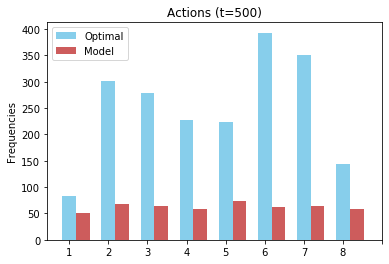

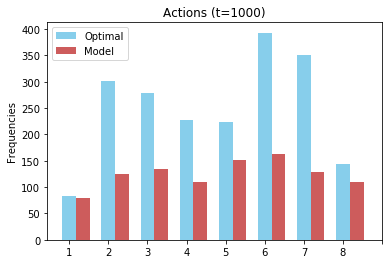

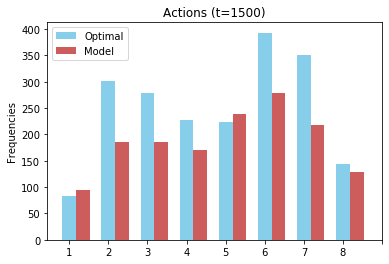

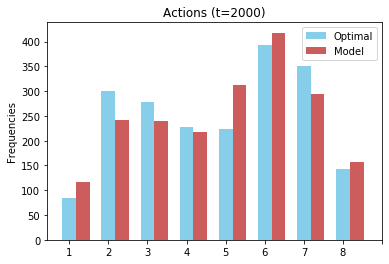

In [8]:
neural_bandit = NeuralLinearPosteriorSampling('neural_bandit', hparams_nlinear)

oaf, maf, rewards, actions = run_bandit(model=neural_bandit, hparams=hparams_nlinear, num_contexts=2000, pct_zero=0, plot=True)

In [9]:
import numpy as np

import matplotlib.pyplot as plt

In [14]:
def grid_search():

    zero_range = np.logspace(0.8, 0.99, 10)/10

    chi_score = []
    rewards = []
    optimal_choice_frequency = []
    model_action_frequency = []
    
    for i in zero_range:
        
        neural_bandit = NeuralLinearPosteriorSampling('neural_bandit', hparams_nlinear)
        
        oaf, maf, reward, action = run_bandit(model=neural_bandit, hparams=hparams_nlinear, num_contexts=2000, pct_zero=i, plot=True)
        
        optimal_choice_frequency.append(oaf)
        model_action_frequency.append(maf)
        rewards.append(reward)
        
    fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
        
    for idx, r in enumerate(rewards):
        ax1.plot(np.cumsum(r), label = "{}%".format(round(zero_range[idx], 2)))
        
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    return optimal_choice_frequency, model_action_frequency, rewards, actions

Ran 2000 iterations in 49.747756004333496 seconds
Ran 2000 iterations in 58.81771802902222 seconds
Ran 2000 iterations in 50.3877649307251 seconds
Ran 2000 iterations in 48.20485591888428 seconds
Ran 2000 iterations in 48.341675758361816 seconds
Ran 2000 iterations in 51.21256685256958 seconds
Ran 2000 iterations in 46.709840059280396 seconds
Ran 2000 iterations in 45.26036500930786 seconds
Ran 2000 iterations in 45.18949818611145 seconds
Ran 2000 iterations in 45.52921485900879 seconds


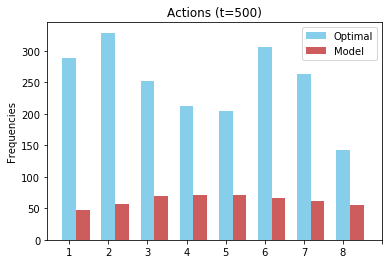

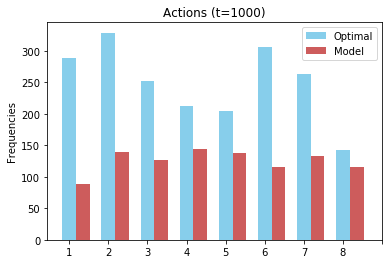

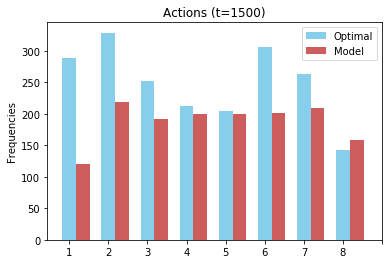

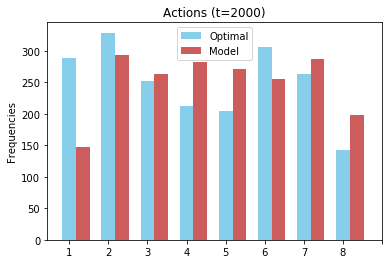

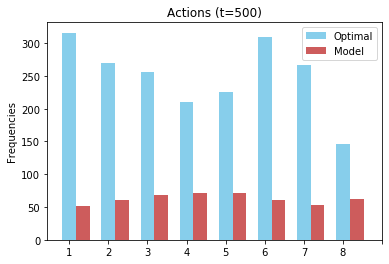

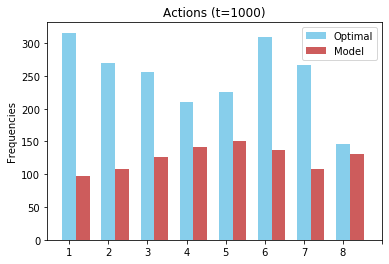

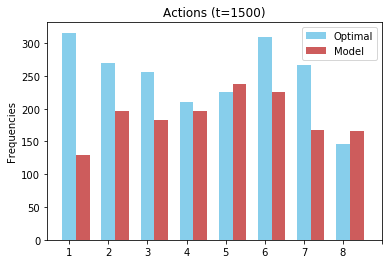

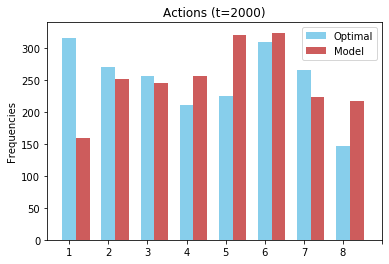

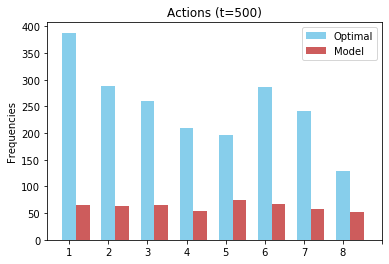

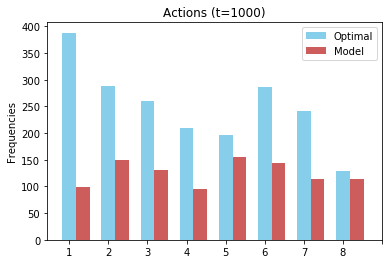

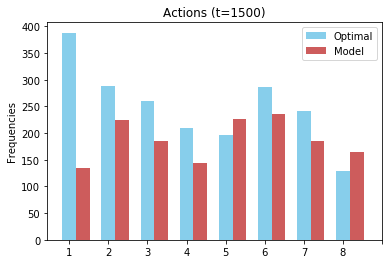

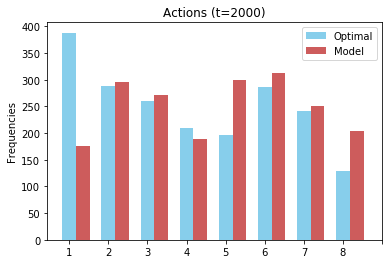

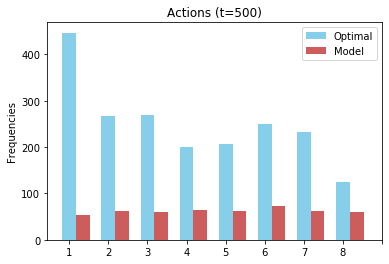

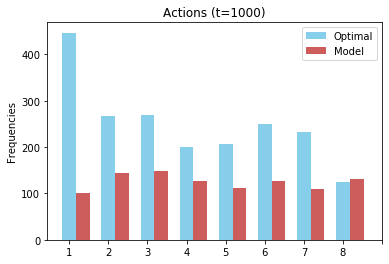

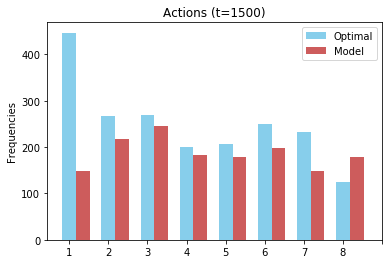

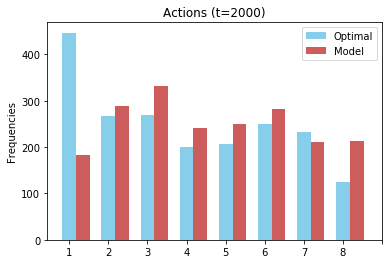

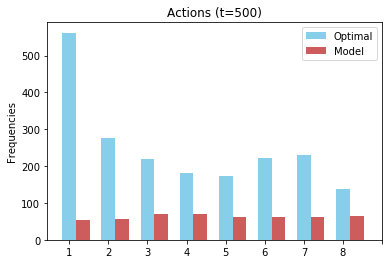

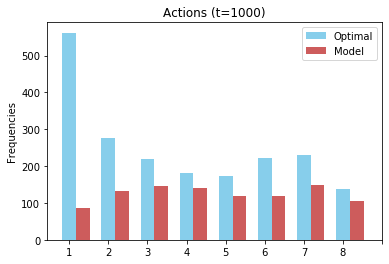

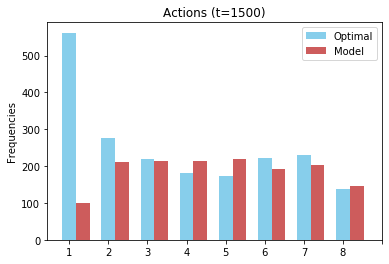

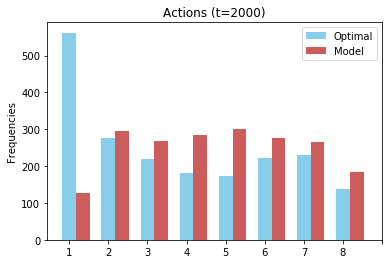

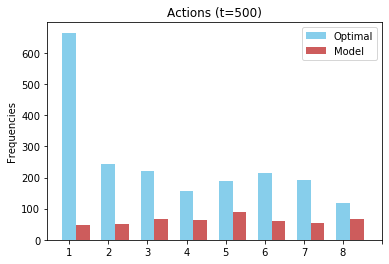

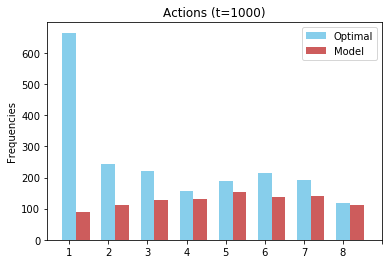

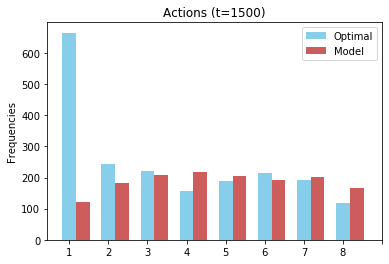

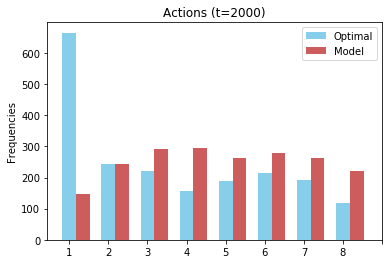

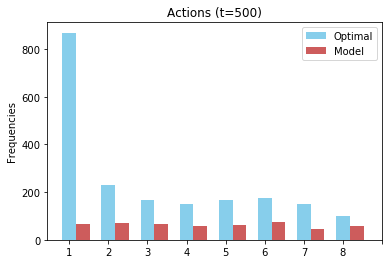

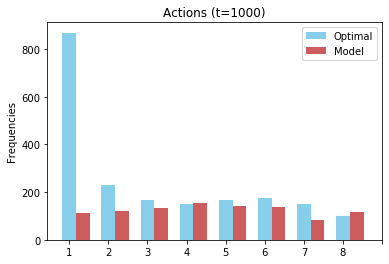

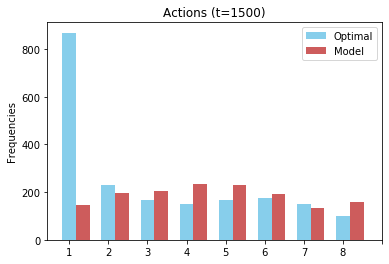

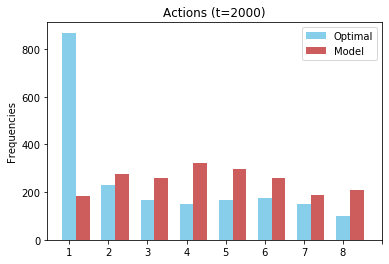

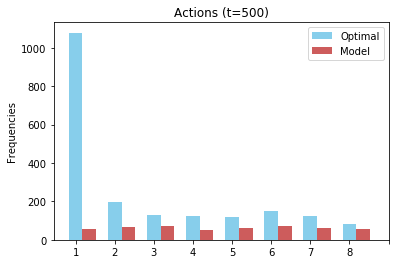

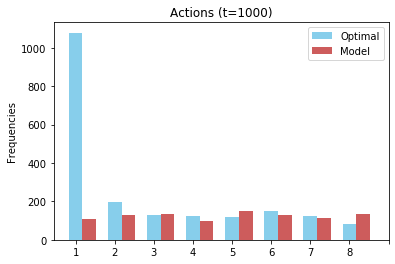

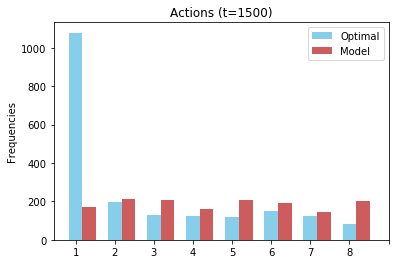

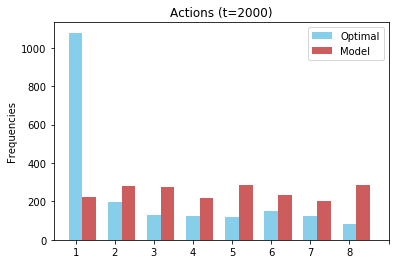

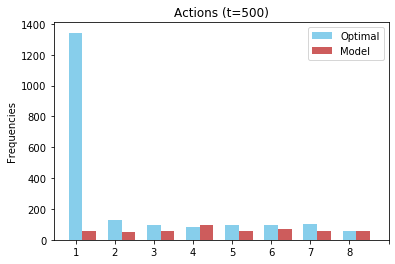

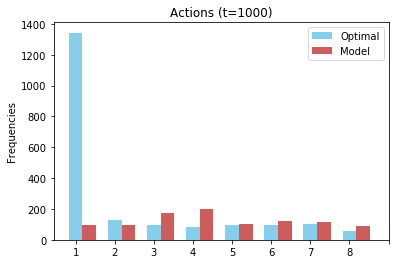

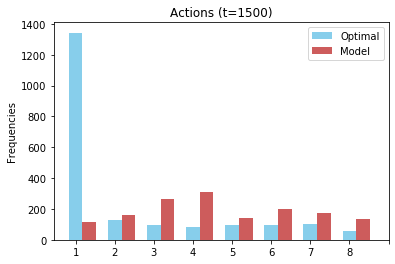

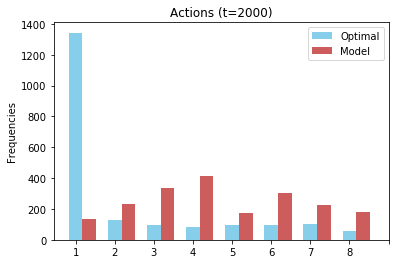

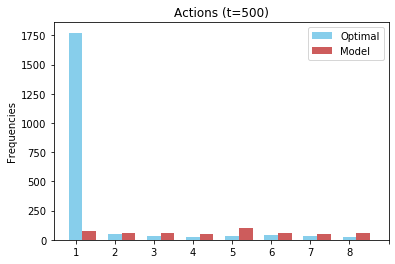

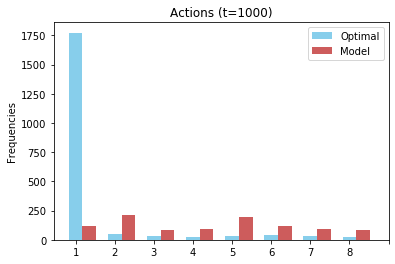

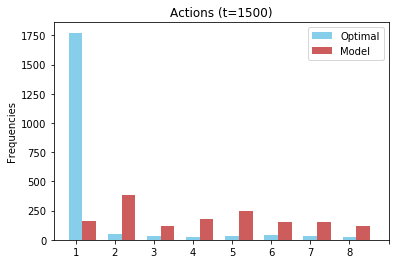

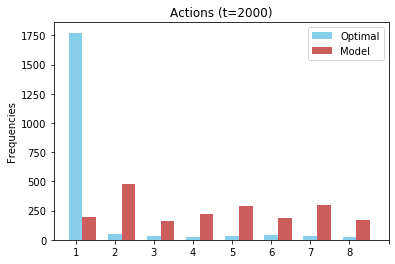

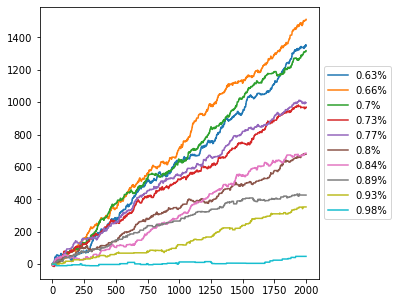

In [15]:
loaf, lmaf, rewards, actions = grid_search()

In [16]:
from scipy.stats import chisquare

3.422 0.578
3.368 0.632
3.224 0.776
3.106 0.894
2.876 1.124
2.67 1.33
2.262 1.738
1.842 2.158
1.314 2.686
0.456 3.544


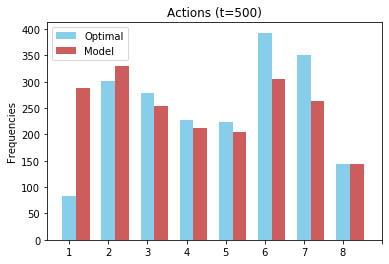

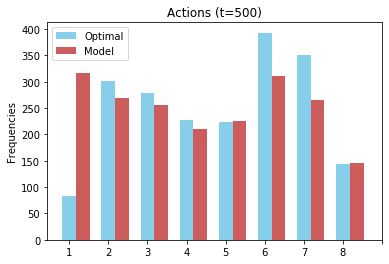

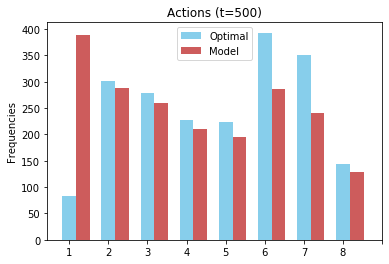

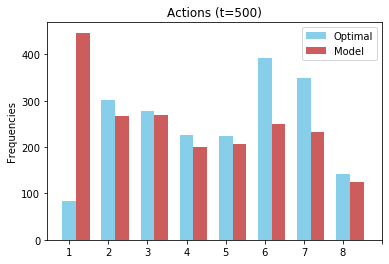

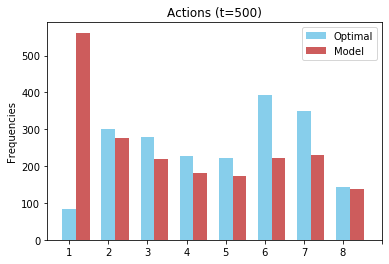

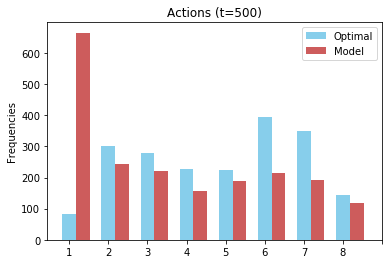

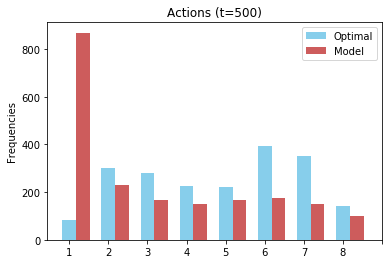

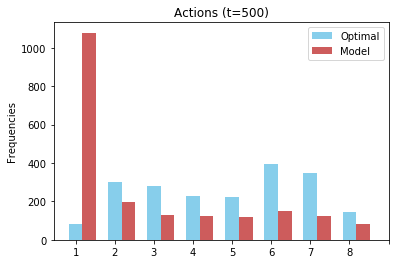

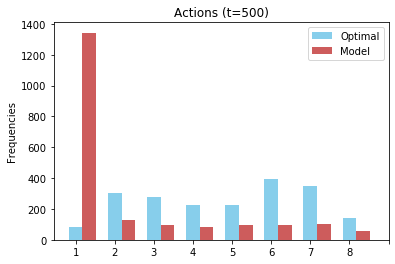

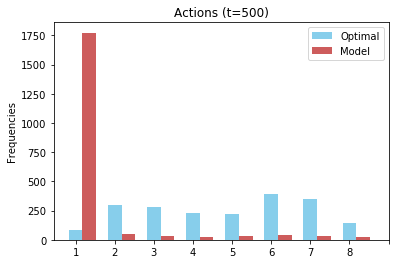

In [17]:
cs = []

for actions in loaf:
    cs.append(chisquare(actions[1:], f_exp=oaf[1:])[0])
    plot_model_actions(oaf, actions, 500)
    print(sum(actions[1:])/500, actions[0]/500)

In [ ]:
plt.plot(cs)